# Logistic model - analysis by genus

## Imports

In [1]:
# IMPORT THE NECESSARY LIBRARIES
import pandas as pd
import re # This module provides functions for working with regular expressions allowing search, match and manipulate strings based on patterns
import os # This module allows interaction with the operating system, such as working with files, directories, environment variables, and system commands.
import sys # This module provides access to system-specific parameters, including command-line arguments (sys.argv), standard input/output, and exiting the program (sys.exit()).
import matplotlib.pyplot as plt
import scipy.optimize as opt
from matplotlib.ticker import MaxNLocator
from statsmodels.graphics.tsaplots import plot_acf # This function is used for plotting the Autocorrelation Function (ACF), which is helpful in time series analysis to measure how observations are correlated with their past values.
from mice_inspection_utils import * # Import all functions 
                                    # NOTICE: this is different from import mice_inspection_utils! In that case you'd have to use the module name as a prefic to access functions, classes or variables. E.g. mice_inspection_utils.some_function()
from scipy.stats import linregress
from glob import glob

# This part avoids possible conflict due to the structure of mice_inspection_utils
if not os.path.exists('Data/by_mouse_genus_aggregated'): 
    print('Missing data aggregated by mouse! Creating a new directory')
    os.makedirs('Data/by_mouse_genus_aggregated')


## Dissimilarity computation

First of all we create the dataframes with the dissimilarity values for each mouse. 

In [2]:
mice_diss = []
oracle_file = os.path.join(os.getcwd(), "Data" ,"dissimilarities_genus")  # Construct the path Data/dissimilarities_genus in the current working directory (cwd)
                                                                    # "oracle" because is a source of truth or knowledge (folder that if exists, that's what we get data from)

if not os.path.exists(oracle_file): # If the folder does not exist, compute and store dissimilarities
    for mouse in range(1,9): 
        df = get_dissimilarities_genus(mouse=mouse, write = True)
        mice_diss.append(df)
    print("Database created")
else: # If the file exists, load precomputed dissimilarities
    for mouse in range(1,9): 
        folder_path = os.path.join(oracle_file, f"dissimilarity_{mouse}.csv")
        csv_files = glob(folder_path)  # Get all CSV file in folder (in general glob finds all files that match a pattern)
        df_list = [pd.read_csv(file,index_col=0)  for file in csv_files]   # Read and merge all files
        mice_diss.append(pd.concat(df_list,ignore_index=False))
        
    print("Data take from files; if you want to compute again delete folder")

Data take from files; if you want to compute again delete folder


In [3]:
# Check that it was built correctly considering for example the last mouse
mice_diss[0].head()

,1,2,3,4,5,6,7,8,9,10,...,1027,1028,1029,1030,1031,1034,1035,1036,1038,1043
Prevotella,0.096184,0.099142,0.052237,0.089583,0.089607,0.081694,0.126108,0.122148,0.149714,0.117020,...,0.704813,1.000000,0.758158,1.000000,1.000000,0.989011,1.000000,1.000000,1.000000,1.000000
Lactobacillus,0.179885,0.202713,0.177746,0.188134,0.273806,0.186859,0.268938,0.254007,0.273883,0.205365,...,0.395041,0.929616,0.526797,0.082031,0.002005,0.947064,0.331497,0.148442,0.939408,0.879135
Clostridium,0.194281,0.211572,0.205727,0.193563,0.168496,0.204474,0.209178,0.270833,0.186927,0.244429,...,0.425679,1.000000,0.423987,0.808868,0.027564,0.971493,0.935109,0.397870,1.000000,1.000000
Barnesiella,0.161913,0.047544,0.057624,0.092800,0.123714,0.077136,0.139385,0.091546,0.120884,0.113731,...,0.663303,1.000000,0.554075,1.000000,0.972415,0.987180,1.000000,0.987097,1.000000,1.000000
Parabacteroides,0.062514,0.085692,0.051627,0.052477,0.086021,0.070248,0.085004,0.074072,0.090297,0.080285,...,0.675035,1.000000,0.718854,1.000000,1.000000,0.982380,1.000000,1.000000,1.000000,1.000000


Let's now have a graphical visualization of these dissimilarities

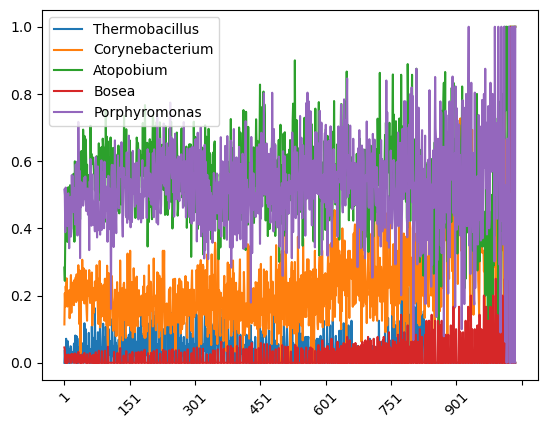

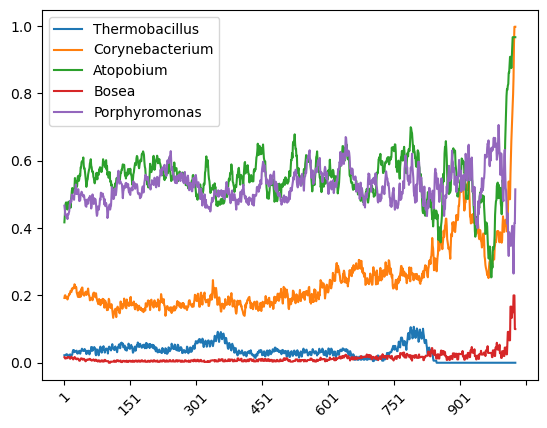

In [4]:
# For the first mice (mice_diss[0])
genuses = np.asarray(mice_diss[0].index)
n_genuses = 5
rnd_idx = np.random.choice(np.arange(len(genuses)), n_genuses)
lags = np.asarray(mice_diss[0].columns)

for ge in genuses[rnd_idx]: 
    data = mice_diss[0].loc[ge].values
    plt.plot(lags, data, label = ge)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Let's smooth the data a bit for better visualization
def moving_average(data, window_size=5): #This means that for each point t, we take the average of the previous W points.
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

for ge in genuses[rnd_idx]: 
    data = mice_diss[0].loc[ge].values
    smoothed_data = moving_average(data, window_size=10)
    plt.plot(lags[:len(smoothed_data)], smoothed_data, label=ge)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=45)
plt.legend()
plt.show()   


In [5]:
plot_dissimilarities_genus_in_pdf(mice_diss, n_genus_per_plot=5, window_size=10, ma = True)

PDF files already exist in Inspection_Outputs\dissimilarityplots_genus. Delete directory Inspection_Outputs\dissimilarityplots_genus to regenerate plots.


## Linear fit of dissimilarities


NOTICE: To discriminate between stationary and non-stationary abundancies perform a linear fit, set a threshold and discriminate slopes above/below that threshold.

In [6]:
# Discard the initial transient (T > 10) 
for idx, mouse_df in enumerate(mice_diss): 
    mice_diss[idx] = mouse_df.drop(mouse_df.columns[:10], axis=1)

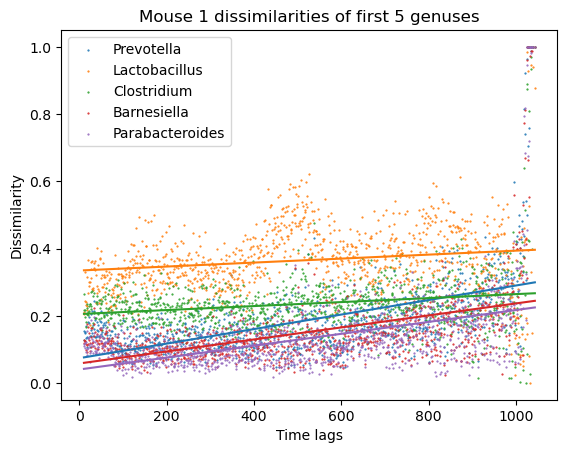

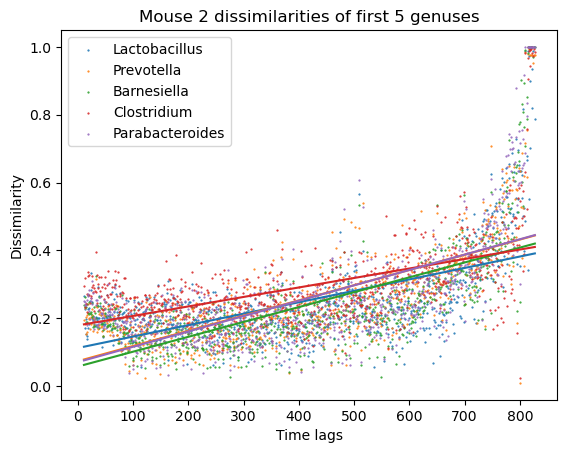

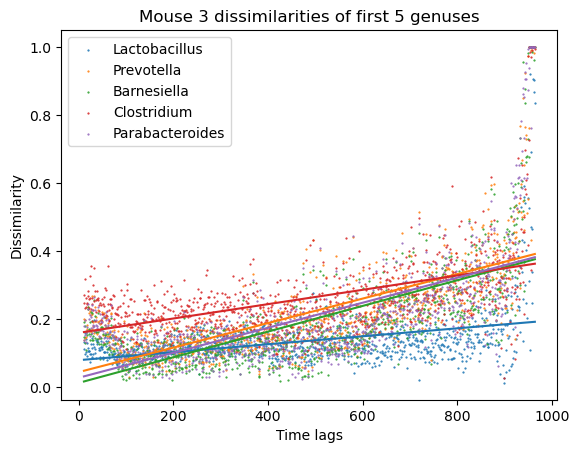

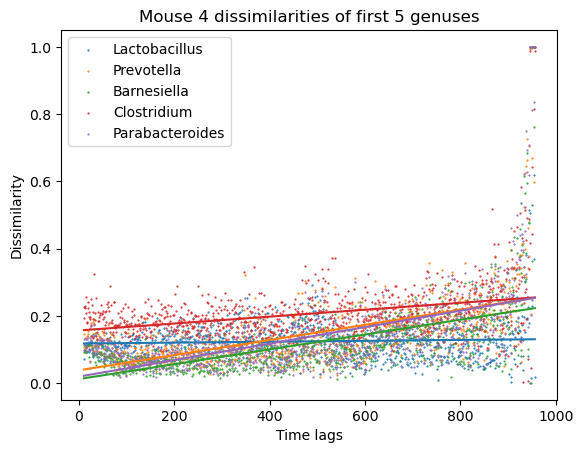

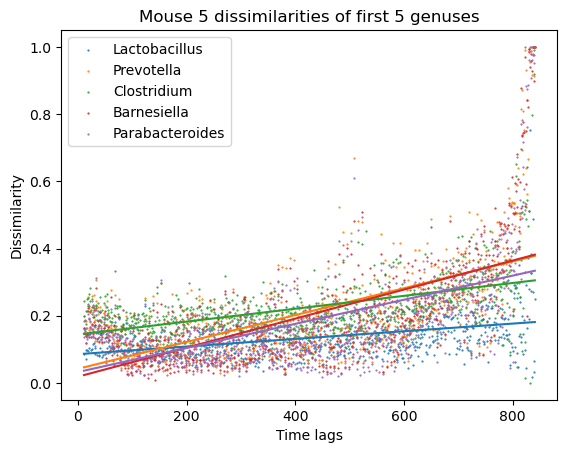

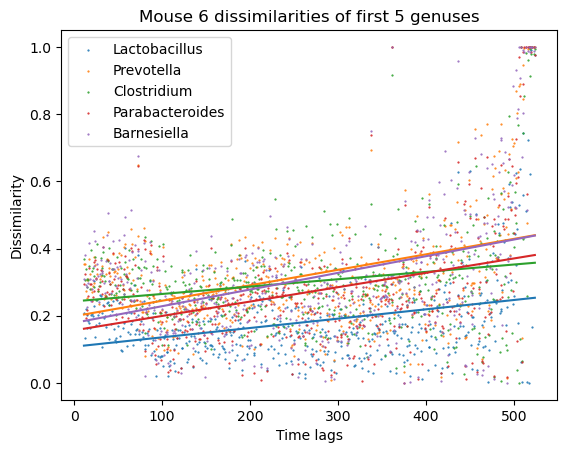

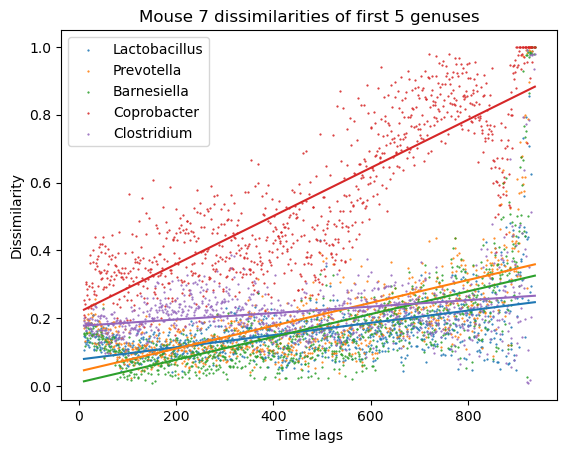

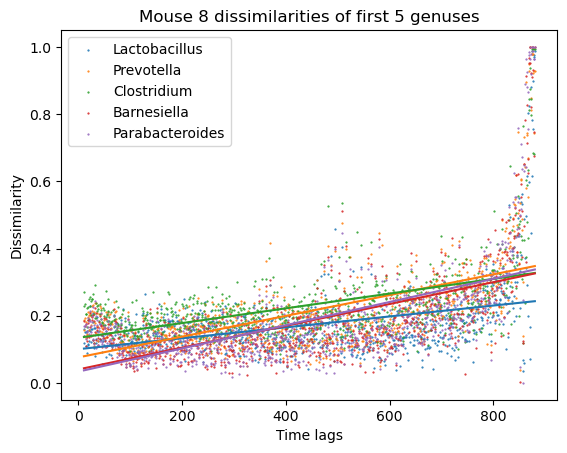

In [7]:
# Perform a linear fit
for idx, mouse_df in enumerate(mice_diss): 
    data = mouse_df.head(5)
    ge_m = []
    ge_q = []
    ge_pred = []
    for ge_idx in range(len(data)): 
        ge_data = np.asarray(data.iloc[ge_idx, :])
        lags = np.asarray(data.columns, dtype = int)
        m, q, *_ = linregress(lags, ge_data)
        pred_data = m*lags + q
        ge_m.append(m)
        ge_q.append(q)
        ge_pred.append(pred_data)
        plt.scatter(lags, ge_data, s = 0.3, label = f'{mouse_df.index[ge_idx]}')
        plt.plot(lags, pred_data)
        plt.xlabel("Time lags")
        plt.ylabel("Dissimilarity")
    plt.title(f"Mouse {idx + 1} dissimilarities of first 5 genuses")
    plt.legend()
    plt.show()


In [8]:
plot_dissfit_genus_in_pdf(mice_diss, n_genus_per_plot=5)

PDF files already exist in Inspection_Outputs\dissimilarityfit_genus. Delete directory Inspection_Outputs\dissimilarityfit_genus to regenerate plots.


## Identify the threshold for increasing curves

"To establish the threshold, we accounted for the fact that, although we
expect a flat dissimilarity if the abundance is stationary, a slope different from zero can be found because of the noise in the estimation of $\Phi$, which depends on the length and density of the time series, on the
sequencing depth, and from the Genus parameters. Therefore, for each individual, we computed the threshold as follows:

1.  We simulated the dynamics of each Genus according to the SLM with parameters equal to the parameters estimated for that Genus and $\tau$ = 1. 

2. From these time series of $\vec{\lambda}$, we sampled the time series of $\vec{x}$ according to the sampling depth of the corresponding samples in the data, obtaining therefore values of $\vec{x}$ only for days for which the individual was sampled. 

3. We then computed $\tilde{\Phi}_i(T)$ and its slope for each
Genus. We defined as threshold for an individual the 95% quantile of
the slopes obtained for that individual, i.e., the value such that only
5% of slopes obtained from the simulation are larger." 

(from the article)

NOTICE: If you **do not** select only the synthetic data corresponding to the days the real data was sampled, your **threshold estimation will be biased** because the noise characteristics of your simulated data will differ from the real dataset. Here’s why:  

1. **More Frequent Sampling → Lower Noise in Dissimilarity Estimation**  
   - In the real dataset, sampling is sparse and irregular, which introduces variability in the observed slopes of $\tilde{\Phi}_i(T)$.  
   - If your simulation includes **more frequent or evenly spaced** samples than the real data, the estimated slopes will be smoother (less noise).  
   - As a result, your threshold for detecting "true" changes will be **too low**, leading to **false positives**—i.e., you might classify OTUs as "increasing" when they are actually fluctuating within noise levels.  

2. **Mismatch Between Real and Simulated Data**  
   - The original approach ensures that the **synthetic dataset mimics the structure of the real dataset**, so both are affected by similar noise due to sampling depth and frequency.  
   - By keeping all synthetic data points, you're introducing an **unrealistically high-resolution time series**, which makes the simulated slopes appear smaller than they would under real sampling conditions.  

3. **Risk of Underestimating Expected Noise**  
   - The threshold is based on the **natural variation of slopes under stationary conditions** in the SLM.  
   - If your simulated slopes are artificially stable due to oversampling, your estimated 95% quantile will be **too low**, and you may incorrectly identify more OTUs as having significant trends when, in reality, they are just affected by sparse real-world sampling.  

##### Expected Outcome:
- **If you include all synthetic data points:** The threshold will be **too strict**, and you will detect more **false trends** in the real data.  
- **If you subsample only the corresponding real sampling days:** The threshold correctly reflects the noise expected due to sampling limitations, preventing **false positives**.  

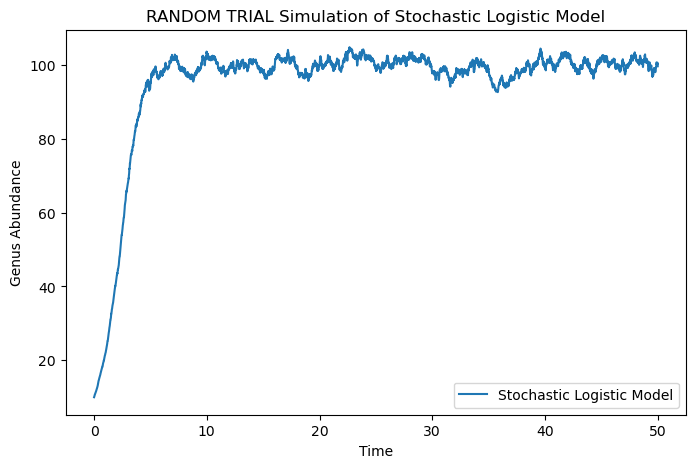

In [9]:
# Define the function to simulate a stochastic logistic model

def simulate_SLM(ab0, K, sigma, tau, steps, dt): 
    ab_vals = np.zeros(int(steps) + 1) # This is gonna be a vector of abundances at each time t for that genus of that mouse
    ab_vals[0] = ab0
    for t in range(1, steps + 1): 
        ab = ab_vals[t-1]

        #--------- useful print for eventual debugging-----------------#
        growth_term = (ab/tau) * (1 - (ab / K))
        noise_term = ab * np.sqrt(sigma/tau) * np.random.normal()
        update = (growth_term + noise_term) * dt[t-1]

        #print(f"Step {t}: ab={ab}, growth={growth_term}, noise={noise_term}, update={update}")

        #--------------------------------------------------------------# 
        
        ab_vals[t] = ab + ( (ab/tau)*(1 - (ab / K)) +  ab * np.sqrt(sigma/tau) * np.random.normal() ) * dt[t-1]
        # Prevent numerical issues
        #ab_vals[t] = max(0, min(ab_vals[t], 1*K))  # Ensuring non-negative & not exploding (K is the maximum sustainable population size given the environmental constraints)
        ab_vals[t] = max(0, ab_vals[t])
    return ab_vals

# Random trial just to see if the function defined above works

# Parameters
ab0 = 10   # Initial population size
K = 100    # Carrying capacity
sigma = 0.1  # Noise intensity
tau = 1.0  # Characteristic time scale
steps = 5000  # Number of steps
dt = np.asarray([0.01]*steps)  # Time step

# Run simulation
ab_vals = simulate_SLM(ab0, K, sigma, tau, steps, dt)

# Plot results
time_vals = np.linspace(0, steps * dt[0], steps + 1)
plt.figure(figsize=(8, 5))
plt.plot(time_vals, ab_vals, label="Stochastic Logistic Model")
plt.xlabel("Time")
plt.ylabel("Genus Abundance")
plt.title("RANDOM TRIAL Simulation of Stochastic Logistic Model")
plt.legend()
plt.show() 

#### NOTICE: 
Our aim is to generate data from a Stochastic Logistic Model that could be consistent with the data. 
Therefore, we need to estimate what are the values of K and sigma that we expect from the data. 
To do this, we can use the theoretical relationships known for the average abundance and standard deviation of the abundance at stationarity (when sigma < 2).

"The model does not include interaction among species and therefore cannot reproduce patterns of interspecies correlation but correctly reproduces several patterns of the dynamics of a single species (15, 16).  

If $\sigma < 2$, the stationary distribution is gamma:

$$
P(\lambda; K, \sigma) = \frac{1}{\Gamma(2/\sigma - 1)} \left( \frac{2 - \sigma}{K} \right)^{\frac{2}{\sigma} -1} \lambda^{\frac{2}{\sigma} -2} e^{-\frac{2}{\sigma K} \lambda}
$$

with mean  

$$
\langle \lambda \rangle = K \frac{2 - \sigma}{\sigma}
$$  

and variance  

$$
\text{var}(\lambda) = \frac{\langle \lambda \rangle^2}{2 - \sigma}.
$$  

" (from the article). 

Hence we must: 

- Find the transient to stationarity and discard it (this can be done by fitting the data with a non-stochastic logistic model, which also gives us a hint of the parameter K); 

- Compute mean and standard deviation of the collected abundances (data); 

- Estimate the parameters from the theoretical values. 

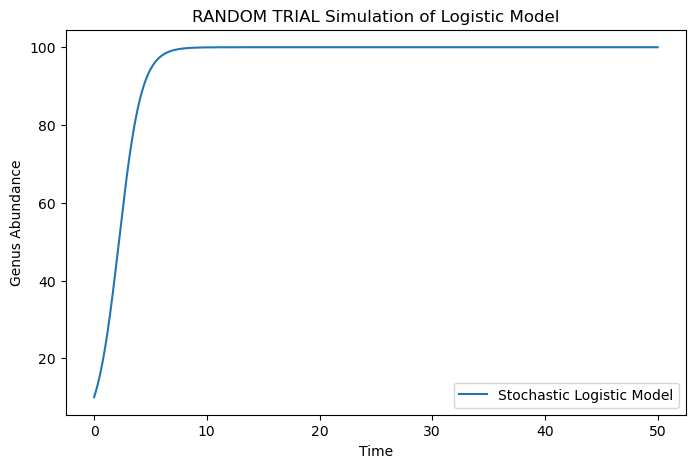

In [10]:
# DEFINE THE LOGISTIC MODEL FUNCTION (non-stochastic)

def LM(ab0, K, tau, steps, dt): 
    ab_vals = np.zeros(int(steps) + 1) # This is gonna be a vector of abundances at each time t for that genus of that mouse
    ab_vals[0] = ab0
    for t in range(1, steps + 1): 
        ab = ab_vals[t-1]
        ab_vals[t] = ab + (ab/tau)*(1 - (ab / K)) * dt[t-1]
        # Prevent numerical issues
        ab_vals[t] = max(0, min(ab_vals[t], 1*K))  # Ensuring non-negative & not exploding (K is the maximum sustainable population size given the environmental constraints)
    return ab_vals

# Random trial just to see if the function defined above works

# Parameters
ab0 = 10   # Initial population size
K = 100    # Carrying capacity
sigma = 0.1  # Noise intensity
tau = 1.0  # Characteristic time scale
steps = 5000  # Number of steps
dt = np.asarray([0.01]*steps)  # Time step

# Run simulation
ab_vals = LM(ab0, K, tau, steps, dt)

# Plot results
time_vals = np.linspace(0, steps * dt[0], steps + 1)
plt.figure(figsize=(8, 5))
plt.plot(time_vals, ab_vals, label="Stochastic Logistic Model")
plt.xlabel("Time")
plt.ylabel("Genus Abundance")
plt.title("RANDOM TRIAL Simulation of Logistic Model")
plt.legend()
plt.show()

In [11]:
# PREPARE DATA FOR THE FIT (we want to fit abundancies, our epirical time series)
# Let's get the data cleaning it from the columns that do not correspond to genus names or abundancies
# Indeed if you print(mi.mice_df) you see there are other information not needed here

mice_ab = []
for mouse_num in range(1,9): 
    mice_df = pd.read_csv(f'Data/by_mouse_genus_aggregated/mouse_{mouse_num-1}_genus.csv')
    columns = mice_df.columns
    mice_ab.append(mice_df.drop(columns = ['median', 'mean']))
#print(mice_ab[0])

#### TRIAL FOR FIRST MOUSE

Estimated K: 631.3112735100142
Estimated tau: 2.6289908689742725


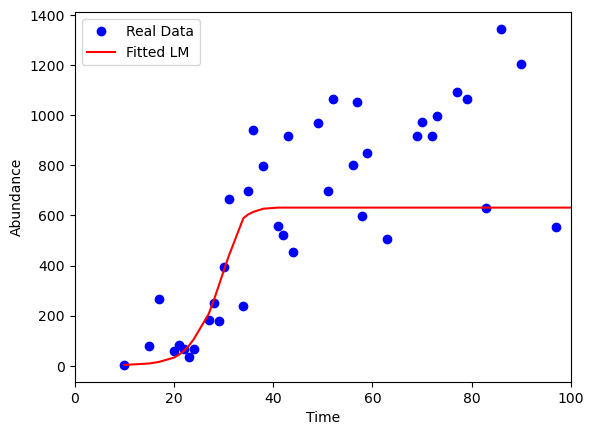

In [12]:
# FIT TO GET THE VALUE OF K --> TRIAL FOR THE FIRST GENUS

# Load the first mouse's data
df = mice_ab[0]
genuses = df['Genus']
ts_data = df.iloc[0, 1:].to_numpy()
nonzero = np.nonzero(ts_data)[0]
start_idx = nonzero[0] + 1  # Adjust for skipped genus column if needed
time_series = df.iloc[0, start_idx:].to_numpy()  # Extract the first genus' time series
days = np.asarray(df.columns[start_idx:], dtype=int)  # Get measurement days
dt = np.diff(days)  # Compute time intervals

# Objective function for optimization
def objective(params, time_series, dt):
    K, tau = params
    simulated_data = LM(
        ab0=time_series[0], K=K, tau=tau, steps=len(time_series)-1, dt=dt
    )
    
    if np.isnan(simulated_data).any():  # Check for NaN values
        return np.inf  # Return a large penalty value
    
    return np.sum((simulated_data - time_series)**2)  # Minimize MSE

# Define parameter bounds
bounds_K = (1, 1e3)  # Carrying capacity
bounds_tau = (0.5, 5.5)  # Timescale parameter
bounds = [bounds_K, bounds_tau]

# Step 1: Use Differential Evolution for Global Search
result = opt.differential_evolution(objective, bounds, args=(time_series, dt), strategy='best1bin')

K_opt, tau_opt = result.x
print(f"Estimated K: {K_opt}")
print(f"Estimated tau: {tau_opt}")

""" --> useless 'cause we get the same
# Step 2: Use L-BFGS-B for Local Refinement
result_refined = opt.minimize(objective, [K_opt, tau_opt], args=(time_series, dt),
                              method='L-BFGS-B', bounds=bounds)

K_opt, tau_opt = result_refined.x
print("\nAfter L-BFGS-B Refinement:")
print(f"Refined K: {K_opt}")
print(f"Refined tau: {tau_opt}")

"""
# Simulate data using refined parameters
fitted_data = LM(
    ab0=time_series[0], K=K_opt, tau=tau_opt, steps=len(time_series)-1, dt=dt
)

# Plot real vs fitted data
plt.plot(days, time_series, 'bo', label="Real Data")
plt.plot(days, fitted_data, 'r-', label="Fitted LM")
plt.xlabel("Time")
plt.ylabel("Abundance")
plt.xlim(0,100) 
plt.legend()
plt.show()

In [13]:
# GET RID OF TRANSIENT -> TRIAL FIRST GENUS

def find_transient_end(time_series, window_size=10, threshold=0.01):
    variances = [np.var(time_series[i-window_size:i]) for i in range(window_size, len(time_series))]
    changes = np.abs(np.diff(variances))  # Change in variance, if small we reached stationarity
    
    for idx, change in enumerate(changes):
        if change < threshold:
            return idx + window_size  # Adjust index due to slicing

    return 0  # If no stable region is found, return 0 (keep all data)

# Discard the initial transient 
# Calculate the time required to reach a certain percentage of K 

transient_end_idx = find_transient_end(fitted_data)  

# Discard the transient phase from the time series

time_series_red = time_series[transient_end_idx:]
days_red=days[transient_end_idx:]


In [14]:
# ESTIMATE THE VALUES OF K AND SIGMA FROM THEORY -- > TRIAL FIRST GENUS
var=np.var(time_series_red)
mean=np.mean(time_series_red)

sigma_th=2*var/(mean**2+var)
K_th=mean*2/(2-sigma_th)

print("Theoretical K:", K_th)
print("Theoretical sigma:", sigma_th)

Theoretical K: 717.1657767803343
Theoretical sigma: 0.2653940828230104


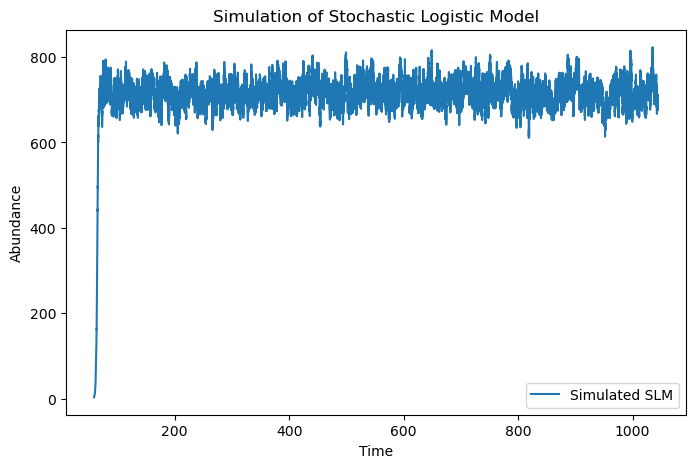

In [15]:
# GENERATE SYNTHETIC DATA USING SLM --> TRIAL FIRST GENUS

# Parameters
ab0 = df.iloc[0,df.iloc[0].to_numpy().nonzero()[0][1]]   # Initial population size --> discarding the first initial points being zero, else we get all zero
K = K_th    # Carrying capacity
sigma = sigma_th  # Noise intensity
tau = 1  # Characteristic time scale --> WE COULD ALSO USE TAU DEFINED ABOVE
# time = np.asarray(df_red.columns, dtype = int)
# dt = [(time[i+1] - time[i]) for i in range(len(time) - 1 )] # Time step
time = np.arange(min(days_red), max(days_red), 0.01)
steps = len(time) - 1
dt = steps*[0.01]

# Run simulation
sim_vals = simulate_SLM(ab0, K, sigma, tau, steps, dt)

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(time, sim_vals, label="Simulated SLM")
plt.xlabel("Time")
plt.ylabel("Abundance")
plt.title("Simulation of Stochastic Logistic Model")
plt.legend()
plt.show() 


To compute the threshold for this first mice, we have to generate this stationarity distribution for all genuses 

### FOR ALL MICE AND GENUSES

In [16]:
def lm_objective(params, time_series, dt):
    K, tau = params
    simulated_data = LM(ab0=time_series[0], K=K, tau=tau, steps=len(time_series)-1, dt=dt)
    
    if np.isnan(simulated_data).any():  
        return np.inf  # Large penalty value
    
    return np.sum((simulated_data - time_series)**2)  # Minimize MSE

def find_transient_end(time_series, window_size=10, threshold=0.01):
    variances = [np.var(time_series[i-window_size:i]) for i in range(window_size, len(time_series))]
    changes = np.abs(np.diff(variances))  # Change in variance, if small we reached stationarity
    
    for idx, change in enumerate(changes):
        if change < threshold:
            return idx + window_size  # Adjust index due to slicing

    return 0  # If no stable region is found, return 0 (keep all data)

# Define parameter bounds
bounds_K = (1, 1e3)  
bounds_tau = (0.5, 5.5)  
bounds = [bounds_K, bounds_tau]

# Store  parameters for all mice and genuses

In [17]:
K_df, tau_df, sigma_df = params_to_csv(mice_ab, objective, bounds, LM, find_transient_end, force_recompute=False)

PDF files already exist in Inspection_Outputs\LMfits. Delete directory Inspection_Outputs\LMfits to regenerate plots.
Loaded K, sigma, tau dataframes from csv files.


In [39]:
# DEFINE THE FUNCTIONS TO COMPUTE DISSIMILARITY AND THRESHOLD --> It's the same function that is in inspection.utils (maybe we can find a way to generalize)

def dissimilarity(simulated_series):
        dissimilarity_data=[]
        days=np.arange(0,len(simulated_series),1)
        valid_day_pairs = {T: {day for day in days if (day + T) in days} for T in range(1, len(simulated_series) + 1)}

# For each genus, compute dissimilarities by time lag
        for T in range(1, len(simulated_series) + 1):
                total_diss = 0
                count = 0
                for day in valid_day_pairs[T]:
                    diss_t = ((simulated_series[day] - simulated_series[day + T]) / 
                            max(1, (simulated_series[day] + simulated_series[day + T])))**2
                    total_diss += diss_t
                    count += 1

                # Only store dissimilarities for time lags with valid days
                if count > 0:
                    dissimilarity_data.append(total_diss / count)
                    
        return dissimilarity_data 

def threshold(start, K_df, sigma_df, df, mouse_num):
    """
    Compute the threshold based on simulated dissimilarity.
    
    Args:
    - start: Starting abundance index for each species.
    - K_df: DataFrame of carrying capacities (species x mice).
    - sigma_df: DataFrame of sigma values (species x mice).
    - df: Abundance DataFrame (species x time points).
    - mouse_num: Integer indicating which mouse's data to process.
    
    Returns:
    - threshold_value: 95th percentile of dissimilarity slopes.
    """
    slopes, sim_serie_diss = [], []

    genus_list = df.index  # Get species names

    # for species in species_list: 
    for geidx, genus in enumerate(genus_list): 
        measurement_days = np.asarray(df.columns[start[geidx]:], dtype=int)
        #if geidx == 0: 
             #print("start", start)
             #print("start shape", np.shape(start))
             #print("start[spidx]")
             # print("measurement days",measurement_days)
        # measurement_days = np.asarray(df.columns[start[specie]:], dtype=int)
        start_day = int(df.columns[start[geidx]])

        # Extract K and sigma values for this species & mouse
        K_val = K_df.loc[genus, f"Mouse {mouse_num+1}"]
        sigma_val = sigma_df.loc[genus, f"Mouse {mouse_num+1}"]

        # Simulate data with theoretical K and sigma
        time_steps = 0.1
        steps = len(measurement_days) * 10 *5  # Total simulation steps
        dt = np.full(steps, time_steps)  # Constant time step

        
        simulated_series = simulate_SLM(
            ab0=start[geidx],  
            K=K_val,
            sigma=sigma_val,
            tau=1.0,  
            steps=steps,
            dt=dt
        )
        
        # Extract simulated values for real measurement days
        nsteps_per_day = int(1 / time_steps)
        indexes_to_extract = np.clip((measurement_days - start_day) * nsteps_per_day, 0, len(simulated_series) - 1)
        simulated_series_sampled = simulated_series[indexes_to_extract]

        # Plot simulation results
        if genus == genus_list[0]:
            time_vals = np.linspace(start_day, steps * time_steps, steps + 1)
            plt.plot(time_vals, simulated_series, label="Stochastic Logistic Model", zorder=1)
            plt.scatter(measurement_days, simulated_series_sampled, color="red", s=20, label="Extracted days", zorder=2)
            plt.xlabel("Time")
            plt.ylabel("Abundance")
            plt.title(f"Simulated SLM sampled as {genus} in mouse {mouse_num+1}")
            plt.legend()
            plt.show()

        # Compute dissimilarity and extract threshold
        simulated_series_diss = dissimilarity(simulated_series_sampled)
        sim_serie_diss.append(simulated_series_diss)

        if genus == genus_list[0]:  # Plot only for the first genus
            plt.scatter(np.arange(len(simulated_series_diss)), simulated_series_diss)
            plt.xlabel("Time Lags")
            plt.ylabel("Dissimilarity")
            plt.title("Simulated series dissimilarity")
            plt.show()

        slope, _, _, _, _ = linregress(np.arange(len(simulated_series_diss)), simulated_series_diss)
        slopes.append(abs(slope))  # Ensure positive slopes

    #threshold_value = np.percentile(slopes, 95)  # 95th percentile as threshold
    threshold_value = np.percentile(slopes, 75)  # 95th percentile as threshold
    return threshold_value


## Stationarity: 

Distinguish OTUs that have stationary dynamics from the others, visualize in a plot $\Phi_i(T)/\Phi_i^\infty$ vs T.  

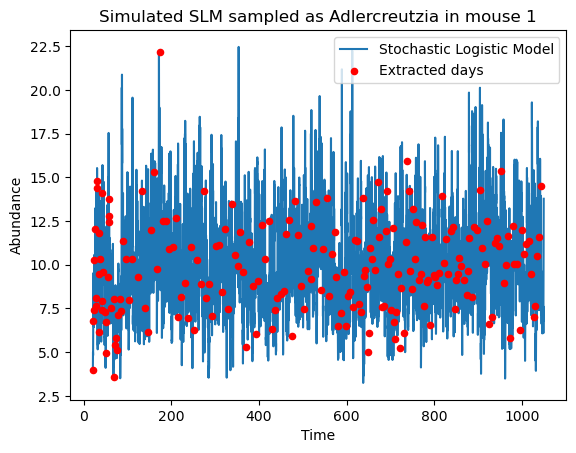

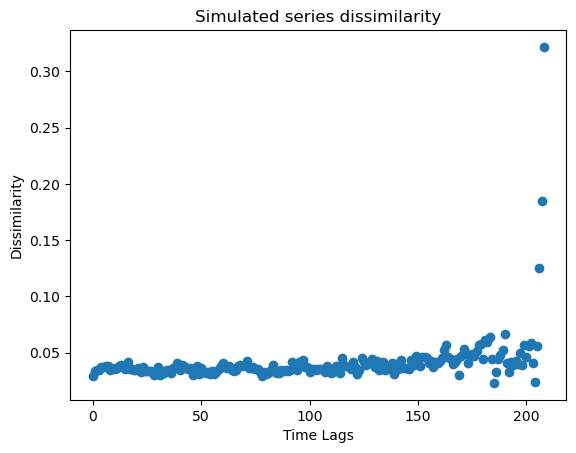

Processing Mouse 1, obtained threshold: 0.0007641493332206312
Trends for Mouse 1 appended to dataframe


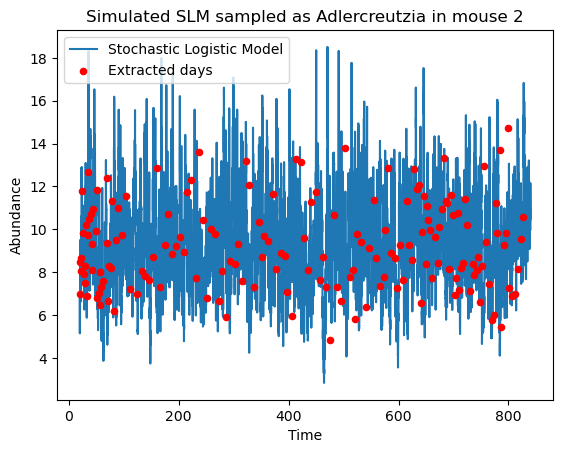

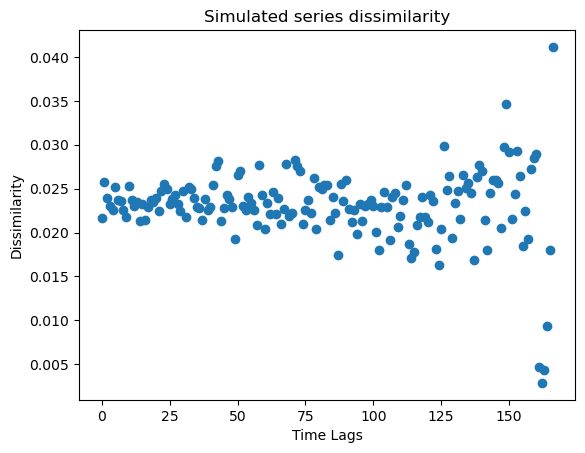

Processing Mouse 2, obtained threshold: 0.0005244442747239044
Trends for Mouse 2 appended to dataframe


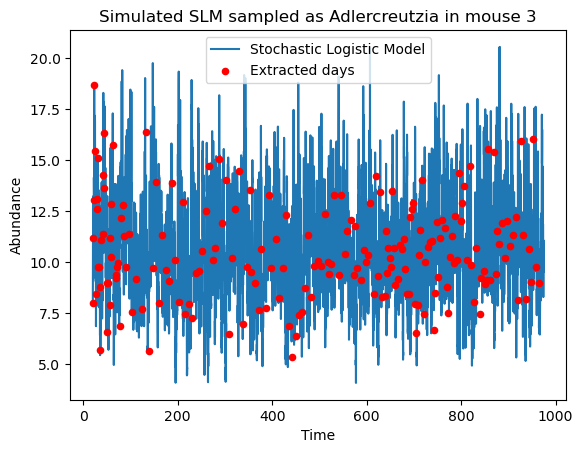

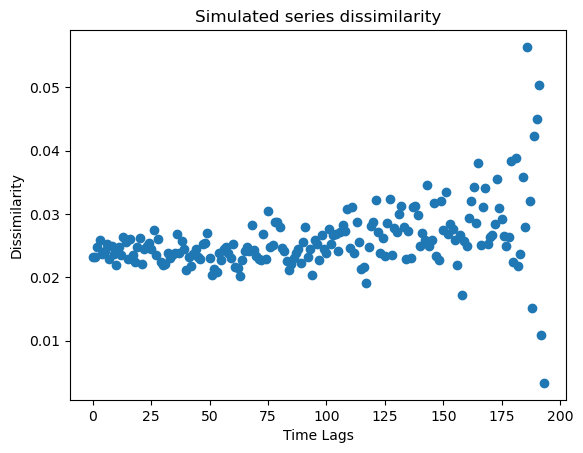

Processing Mouse 3, obtained threshold: 0.0005582653496800444
Trends for Mouse 3 appended to dataframe


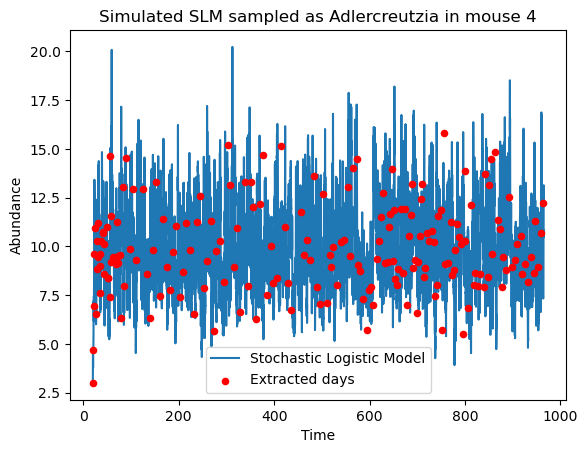

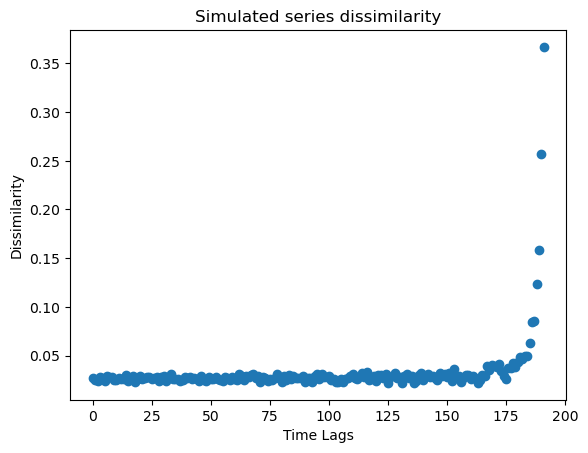

Processing Mouse 4, obtained threshold: 0.0006405693239683586
Trends for Mouse 4 appended to dataframe


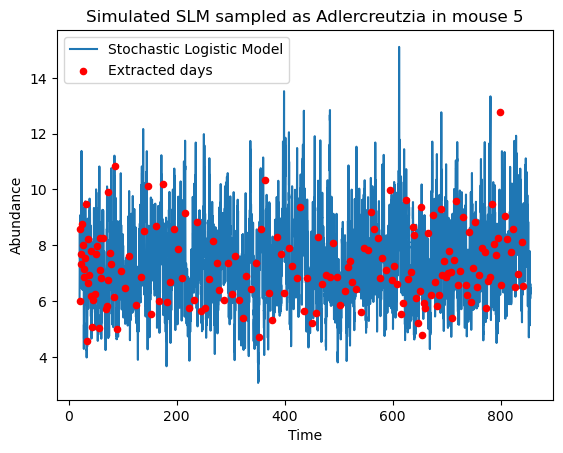

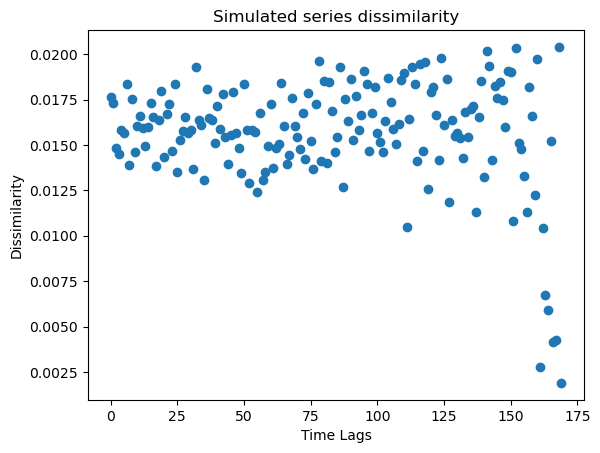

Processing Mouse 5, obtained threshold: 0.00074451050155189
Trends for Mouse 5 appended to dataframe


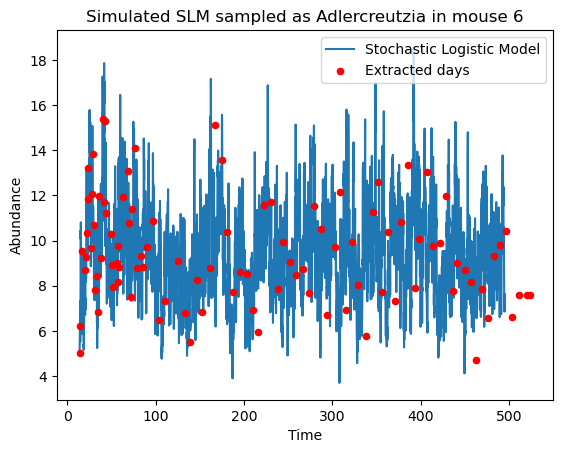

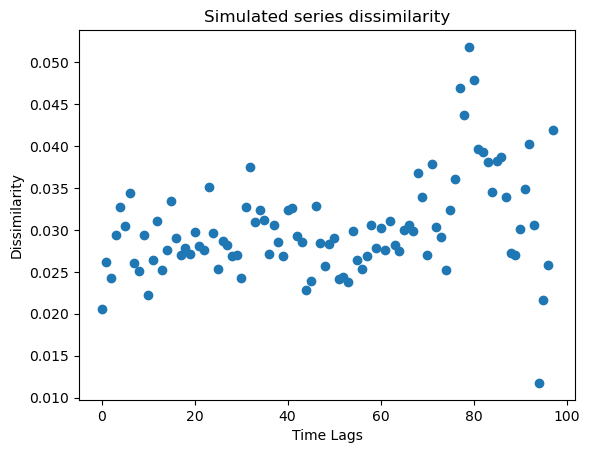

Processing Mouse 6, obtained threshold: 0.0019444069201521468
Trends for Mouse 6 appended to dataframe


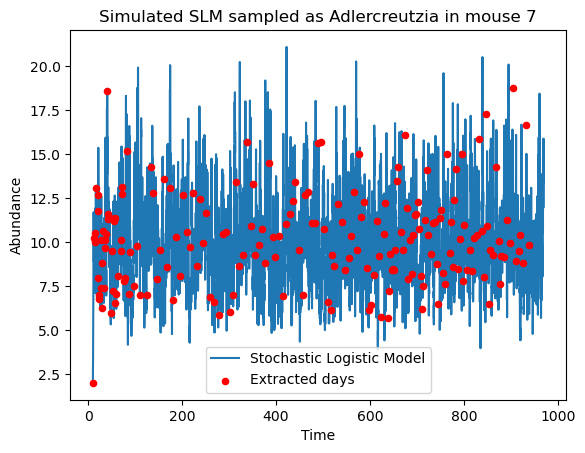

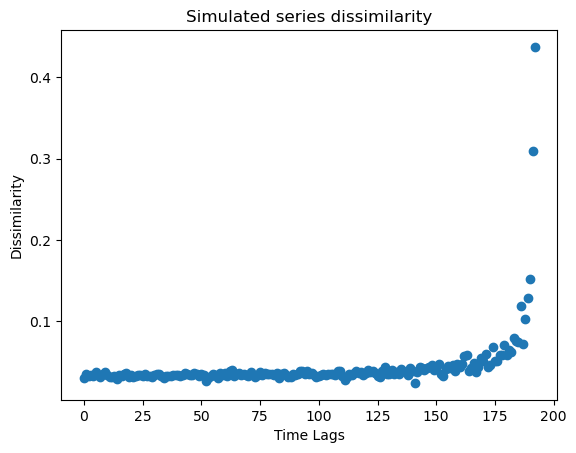

Processing Mouse 7, obtained threshold: 0.00046446083415624346
Trends for Mouse 7 appended to dataframe


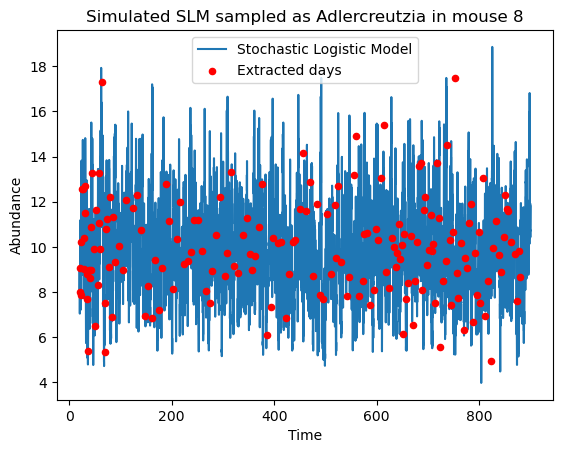

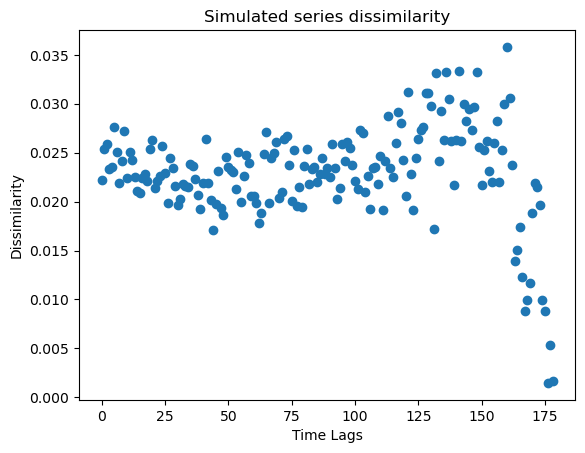

Processing Mouse 8, obtained threshold: 0.0006105635926803327
Trends for Mouse 8 appended to dataframe


In [40]:
# TRY FOR ALL MICE

# Iterate through all mice
# Extract the DataFrame for the current mouse
    
mask= np.any(K_df.isna(),axis=1)
K_filtered = K_df[~mask]
sigma_filtered = sigma_df[~mask]


summary_df = []
for mouse_idx, mouse in enumerate(mice_diss):
    
    # Remove the "TREND" column if it exists (to allow re-running the code)
    if 'TREND' in mouse.columns:
        mouse = mouse.drop(columns=['TREND'], inplace=True)  # Avoid inplace modifications

    df = mice_ab[mouse_idx] 
    df.index=df['Genus']
    K_filtered.index=K_filtered['Genus']
    sigma_filtered.index=sigma_filtered['Genus']
    species_in_both = df.index.intersection(K_filtered.index)
    species_in_both=species_in_both.sort_values() 
    df_filtered = df.loc[species_in_both]


    K_filtered = K_filtered.loc[species_in_both]
    sigma_filtered = sigma_filtered.loc[species_in_both]
 
    # Extract abundance data (excluding metadata columns)
    abundance_data = df_filtered.iloc[:, 1:].to_numpy()

    # Find species with at least one nonzero abundance at any time point
    nonzero_species = np.any(abundance_data > 0, axis=1) 

    if np.sum(nonzero_species) == 0:  # No species with nonzero values
        print(f"Skipping Mouse {mouse_idx + 1} (no nonzero species)")
        summary_df.append(pd.DataFrame())  # Append empty DataFrame for consistency
        continue  

    # For each species, find the index of the first nonzero time point.
    first_nonzero_idx = np.argmax(abundance_data > 0, axis=1)

    # Optionally, handle species that are always zero:
    # first_nonzero_indices = np.where(nonzero_species, first_nonzero_indices, -1)

    # Select the first species that has nonzero abundance
    first_nonzero_idx = np.where(nonzero_species, np.argmax(abundance_data > 0, axis = 1), -1)

    # Ensure indices are within the valid range
    first_nonzero_idx = np.clip(first_nonzero_idx, 0, abundance_data.shape[1] - 1)
    

    # Compute the threshold for the current mouse
    threshold_mouse = threshold(
        #start=start_values,
        start = first_nonzero_idx,
        K_df=K_filtered,  # Pass K values
        sigma_df=sigma_filtered,  # Pass sigma values
        df=df_filtered.iloc[:, 4:],  # Pass only the abundance data
        mouse_num=mouse_idx
    )

    print(f"Processing Mouse {mouse_idx + 1}, obtained threshold: {threshold_mouse}")

    # Store trends for each species
    trend = []

    # Iterate over species in the mouse dataset
    for spec_idx, spec in enumerate(df_filtered.index):  
        time_diss = mouse.loc[spec]

        # Compute the slope using linear regression
        slope_mouse, _, _, _, _ = linregress(np.arange(len(time_diss)), time_diss)

        # Determine the trend based on threshold
        trend.append("incr" if slope_mouse > threshold_mouse else "flat")

    diss_inf_values = sigma_filtered[f"Mouse {mouse_idx + 1}"] / (4 - sigma_filtered[f"Mouse {mouse_idx + 1}"])

    temp_df = pd.DataFrame({
        'TREND': trend,
        'K': K_filtered[f"Mouse {mouse_idx + 1}"].values.flatten(),
        'sigma': sigma_filtered[f"Mouse {mouse_idx + 1}"].values.flatten(),
        'diss_inf': diss_inf_values.values.flatten()
    }, index=species_in_both)

    # Append to summary DataFrame
    summary_df.append(temp_df)

    # Append trend classification to the DataFrame
    mouse.loc[species_in_both]["TREND"] = trend


    print(f"Trends for Mouse {mouse_idx + 1} appended to dataframe")


In [45]:
#print(mice_diss[0])
normalized_diss_list=[]

for mouse_idx in range(len(mice_diss)):
    print("Mouse", mouse_idx, summary_df[mouse_idx][summary_df[mouse_idx]['TREND'] == 'incr'].index)
    selected_species=summary_df[mouse_idx].index
    selected_diss=mice_diss[mouse_idx].loc[selected_species]
    normalized_diss = selected_diss.div(summary_df[mouse_idx]['diss_inf'], axis=0)  # Element-wise division

    normalized_diss_list.append(normalized_diss)  # Store for this mouse

Mouse 0 Index([], dtype='object', name='Genus')
Mouse 1 Index(['Candidatus Arthromitus'], dtype='object', name='Genus')
Mouse 2 Index([], dtype='object', name='Genus')
Mouse 3 Index([], dtype='object', name='Genus')
Mouse 4 Index(['Aureibacter', 'Coprobacter'], dtype='object', name='Genus')
Mouse 5 Index([], dtype='object', name='Genus')
Mouse 6 Index(['Aureibacter', 'Coprobacter', 'Eubacterium', 'Parasutterella'], dtype='object', name='Genus')
Mouse 7 Index(['Coprobacter'], dtype='object', name='Genus')


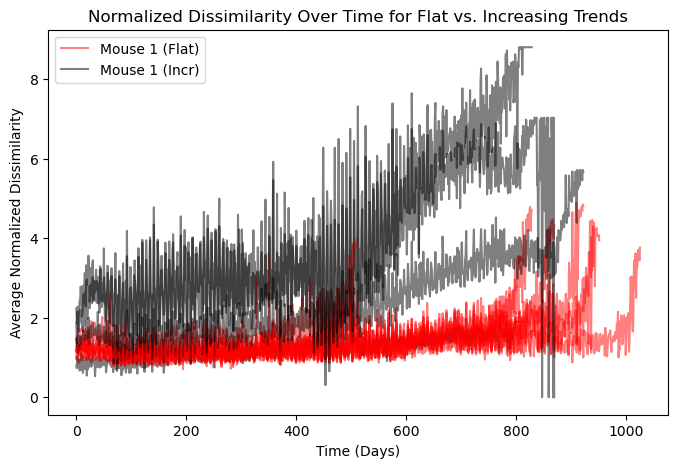

In [42]:
# Create figure
plt.figure(figsize=(8, 5))

# Iterate through each mouse
for mouse_idx in range(len(mice_diss)):
    if summary_df[mouse_idx].empty or normalized_diss_list[mouse_idx].empty:
        print(f"Skipping Mouse {mouse_idx + 1} (empty data)")
        continue

    # Select species based on TREND
    flat_species = summary_df[mouse_idx][summary_df[mouse_idx]['TREND'] == 'flat'].index
    incr_species = summary_df[mouse_idx][summary_df[mouse_idx]['TREND'] == 'incr'].index

    # Compute mean dissimilarity across species (rows) for each trend
    mean_diss_flat = normalized_diss_list[mouse_idx].loc[flat_species].mean(axis=0)  
    mean_diss_incr = normalized_diss_list[mouse_idx].loc[incr_species].mean(axis=0)  

    # X-axis: time points
    time_points = np.arange(len(mean_diss_flat))

    # Plot for the current mouse
    plt.plot(time_points, mean_diss_flat, linestyle='-', color='red', alpha=0.5, label=f'Mouse {mouse_idx+1} (Flat)' if mouse_idx == 0 else "")
    plt.plot(time_points, mean_diss_incr, linestyle='-', color='black', alpha=0.5, label=f'Mouse {mouse_idx+1} (Incr)' if mouse_idx == 0 else "")

# Labels and title
plt.xlabel("Time (Days)")
plt.ylabel("Average Normalized Dissimilarity")
plt.title("Normalized Dissimilarity Over Time for Flat vs. Increasing Trends")
plt.legend()
plt.show()


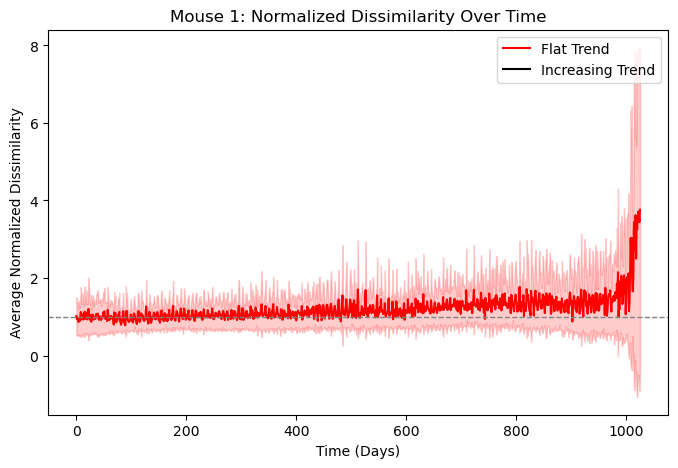

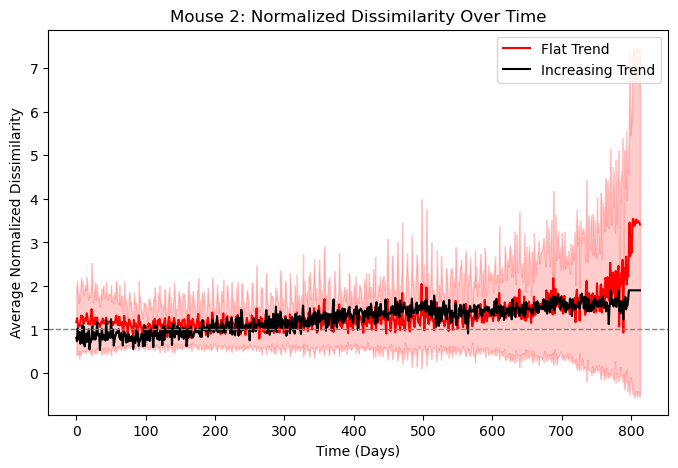

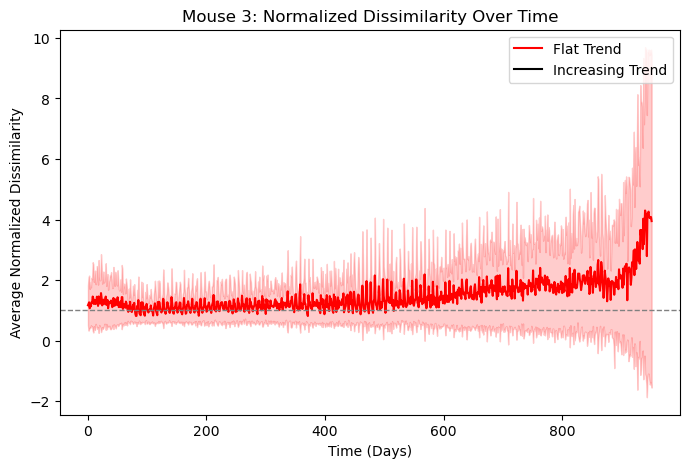

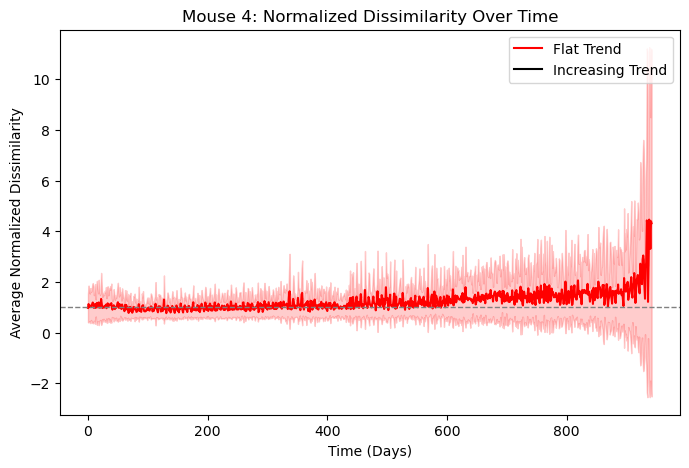

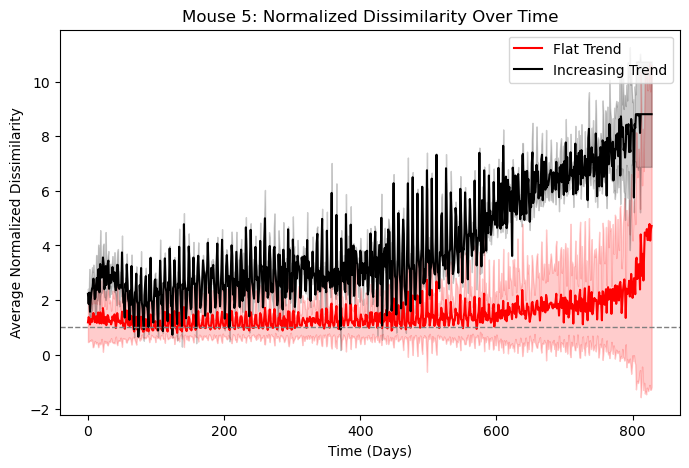

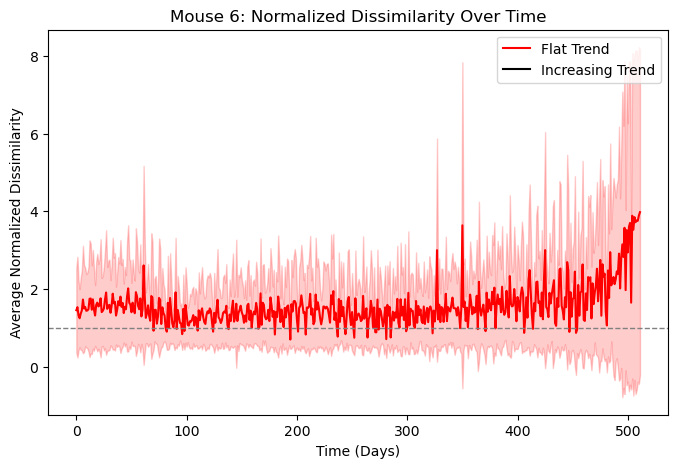

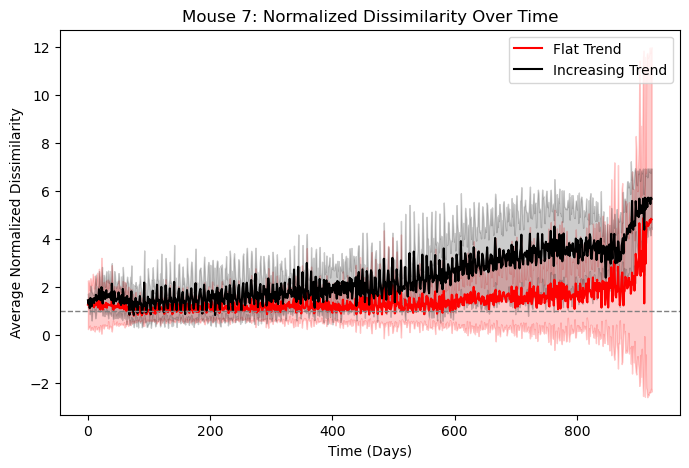

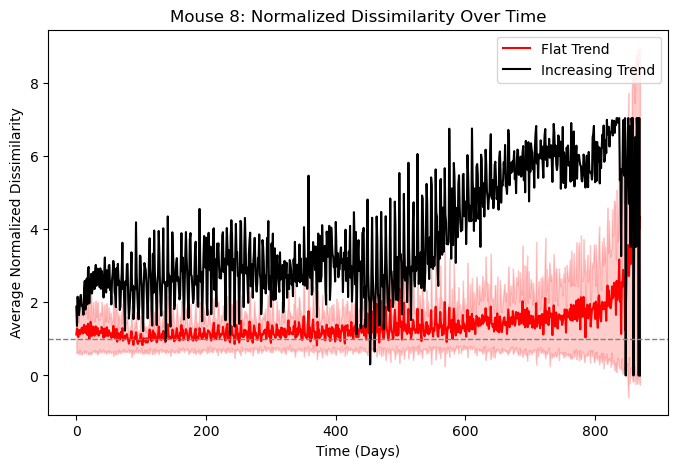

In [43]:
# Iterate through each mouse
for mouse_idx in range(len(mice_diss)):
    if summary_df[mouse_idx].empty or normalized_diss_list[mouse_idx].empty:
        print(f"Skipping Mouse {mouse_idx + 1} (empty data)")
        continue

    # Select species based on TREND
    flat_species = summary_df[mouse_idx][summary_df[mouse_idx]['TREND'] == 'flat'].index
    incr_species = summary_df[mouse_idx][summary_df[mouse_idx]['TREND'] == 'incr'].index

    # Compute mean and standard deviation across species for each trend
    mean_diss_flat = normalized_diss_list[mouse_idx].loc[flat_species].mean(axis=0)  
    std_diss_flat = normalized_diss_list[mouse_idx].loc[flat_species].std(axis=0)

    mean_diss_incr = normalized_diss_list[mouse_idx].loc[incr_species].mean(axis=0)  
    std_diss_incr = normalized_diss_list[mouse_idx].loc[incr_species].std(axis=0)

    # X-axis: time points
    time_points = np.arange(len(mean_diss_flat))

    # Create a new figure for each mouse
    plt.figure(figsize=(8, 5))

    # Plot mean dissimilarities
    plt.plot(time_points, mean_diss_flat, linestyle='-', color='red', label='Flat Trend')
    plt.plot(time_points, mean_diss_incr, linestyle='-', color='black', label='Increasing Trend')

    # Add shaded region (Mean ± SD)
    plt.fill_between(time_points, mean_diss_flat - std_diss_flat, mean_diss_flat + std_diss_flat, color='red', alpha=0.2)
    plt.fill_between(time_points, mean_diss_incr - std_diss_incr, mean_diss_incr + std_diss_incr, color='black', alpha=0.2)

    # Add a horizontal dashed line at y = 1
    plt.axhline(y=1, color='gray', linestyle='dashed', linewidth=1)

    # Labels and title
    plt.xlabel("Time (Days)")
    plt.ylabel("Average Normalized Dissimilarity")
    plt.title(f"Mouse {mouse_idx + 1}: Normalized Dissimilarity Over Time")
    plt.legend()

    # Show plot for this mouse
    plt.show()


maybe lower the percentile of threshold to include more increasing species